# PREPARACIÓN NOTEBOOK
---

## Librerías

In [1]:
from google.colab import drive
import sys
import os
import sqlite3 as sql #Crear y trabajar bases de datos ligeras
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter

## Conexión con la BD y el repositorio en Drive

In [2]:
#Conectar al drive local
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Conectar al repositorio
path = '/content/drive/My Drive/cod/A3_marketing'

sys.path.append(path) #Importar las funciones propias a través de import, porque incluye la carpeta del repositorio como uno de esos paquetes para que import busque funciones
os.chdir(path) #Subir y descargar archivos de la ruta del repositorio de trabajo

## Conexión al notebook de funciones

In [4]:
%run a_funciones.ipynb

# SQL
---

## Conexión

In [7]:
con = sql.connect('Data/db_movies') #Conectarse a la base de datos existente y transportar datos
cur = con.cursor() #Otra conexión (cursor) para ejecutar las consultas en la bd sin traer ni llevar info

In [8]:
#Consultar qué tablas disponibles tiene la bd
cur.execute(""" select name from sqlite_master where type= 'table' """)
cur.fetchall()

[('ratings',), ('movies',)]

## Exploración

In [9]:
tablas_a_explorar = ['ratings', 'movies']
for tabla in tablas_a_explorar:
    explorar_tabla(con, tabla)

------------

Explorando la tabla 'ratings'

Esquema de la tabla 'ratings':
  - Nombre: userId, Tipo: INTEGER, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: movieId, Tipo: INTEGER, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: rating, Tipo: REAL, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: timestamp, Tipo: INTEGER, ¿Nulo?: 0, Clave Primaria: 0

Primeras 10 filas de la tabla 'ratings':
(1, 1, 4.0, 964982703)
(1, 3, 4.0, 964981247)
(1, 6, 4.0, 964982224)
(1, 47, 5.0, 964983815)
(1, 50, 5.0, 964982931)
(1, 70, 3.0, 964982400)
(1, 101, 5.0, 964980868)
(1, 110, 4.0, 964982176)
(1, 151, 5.0, 964984041)
(1, 157, 5.0, 964984100)

Número total de filas en 'ratings': 100836
------------

Explorando la tabla 'movies'

Esquema de la tabla 'movies':
  - Nombre: movieId, Tipo: INTEGER, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: title, Tipo: TEXT, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: genres, Tipo: TEXT, ¿Nulo?: 0, Clave Primaria: 0

Primeras 10 filas de la tabla 'movies':
(1, 'Toy Story (1995)', 'Adventure|Anim

## Exploración profunda: Tabla ratings



In [10]:
try:
    # 1. Conteo de usuarios únicos
    cur.execute("SELECT COUNT(DISTINCT userId) FROM ratings;")
    num_usuarios_unicos = cur.fetchone()[0]
    print(f"Número de usuarios únicos: {num_usuarios_unicos}")

    # 2. Medidas estadísticas
    cur.execute("SELECT AVG(rating), MIN(rating), MAX(rating) FROM ratings;")
    promedio_rating, min_rating, max_rating = cur.fetchone()
    print(f"Promedio de rating: {promedio_rating:.2f}")
    print(f"Rating mínimo: {min_rating}")
    print(f"Rating máximo: {max_rating}")

    # 3. Moda
    cur.execute("SELECT rating FROM ratings;")
    ratings = [row[0] for row in cur.fetchall()]
    if ratings:
        moda_rating = calcular_moda(ratings)
        print(f"Moda del rating: {moda_rating}")
    else:
        print("No hay ratings para calcular la moda.")

except sql.Error as e:
    print(f"Error al explorar la tabla 'ratings': {e}")

Número de usuarios únicos: 610
Promedio de rating: 3.50
Rating mínimo: 0.5
Rating máximo: 5.0
Moda del rating: 4.0


## Exploración profunda: Tabla movies

Para esta exploración se usara la librería de pandas ya que permite una manipulación mas rápida y menos engorrosa de la tabla al realizar los split's y extracciones de fragmentos de la cadena de texto mas rápidamente

In [ ]:
#### original ###

# try:
#     # Consultar la tabla 'movies' y cargarla en un DataFrame de Pandas
#     query = "SELECT * FROM movies"
#     df_movies = pd.read_sql_query(query, con)

#     # Extraer los últimos 6 caracteres de la columna 'title' y crear la columna 'Year'
#     df_movies['Year'] = df_movies['title'].str[-6:]

#     # Limpiar la columna 'Year' removiendo los paréntesis
#     df_movies['Year'] = df_movies['Year'].str.replace(r'\(|\)', '', regex=True)

#     # Separar los géneros de la columna 'genres'
#     df_movies['genres_split'] = df_movies['genres'].str.split('|')

# except sql.Error as e:
#     print(f"Error: {e}")

In [11]:
try:
    # Consulta SQL
    query = "SELECT * FROM movies"
    df_movies = pd.read_sql_query(query, con)

    # Extraer el primer año entre paréntesis (en cualquier parte del título)
    df_movies['Year'] = df_movies['title'].str.extract(r'\((\d{4})\)', expand=False)

    # Crear dos DataFrames: uno con año válido y otro sin año
    df_movies_valid = df_movies[df_movies['Year'].notnull()].copy()
    df_movies_invalid = df_movies[df_movies['Year'].isnull()].copy()

    # Convertir a tipo numérico los años válidos
    df_movies_valid['Year'] = df_movies_valid['Year'].astype(int)

    # Separar los géneros
    df_movies['genres_split'] = df_movies['genres'].str.split('|')

    # Imprimir resultados
    print("\nPelículas con año válido:")
    print(df_movies_valid[['title', 'Year']].head())

    print("\nPelículas SIN año (inválido o ausente):")
    print(df_movies_invalid[['title']].head())

except Exception as e:
    print(f"Error: {e}")


Películas con año válido:
                                title  Year
0                    Toy Story (1995)  1995
1                      Jumanji (1995)  1995
2             Grumpier Old Men (1995)  1995
3            Waiting to Exhale (1995)  1995
4  Father of the Bride Part II (1995)  1995

Películas SIN año (inválido o ausente):
                                                  title
6059                                          Babylon 5
9031                                   Ready Player One
9091                                         Hyena Road
9138  The Adventures of Sherlock Holmes and Doctor W...
9179                                  Nocturnal Animals


In [12]:
df_movies.head()

,movieId,title,genres,Year,genres_split
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,1995,[Comedy]


In [13]:
#Creación de una copia del DF
df_movies1 = df_movies[['movieId', 'title', 'Year', 'genres_split']].copy()
#Eliminación del año en la columna "title"
df_movies1['title'] = df_movies1['title'].str.replace(r'\s*\(\d{4}\)$', '', regex=True)
df_movies1.head()

,movieId,title,Year,genres_split
0,1,Toy Story,1995,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji,1995,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men,1995,"[Comedy, Romance]"
3,4,Waiting to Exhale,1995,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II,1995,[Comedy]


In [14]:
#Separación en columnas de los generos

# 1. Obtener todos los géneros únicos de la columna 'genres_split'
all_genres = df_movies1['genres_split'].explode().unique()

# 2. Crear columnas booleanas para cada género único
for genre in all_genres:
    df_movies1[genre] = df_movies['genres_split'].apply(lambda x: 1 if genre in x else 0)

# 3. Eliminar la columna original 'genres_split'
df_movies1 = df_movies1.drop('genres_split', axis=1, errors='ignore')

In [15]:
df_movies1.head(10)

,movieId,title,Year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story,1995,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,Heat,1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,Sabrina,1995,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,8,Tom and Huck,1995,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,Sudden Death,1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,GoldenEye,1995,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Películas din año
print("\nTabla de películas SIN año (inválido o ausente):")
display(df_movies_invalid[['movieId', 'title', 'genres', 'Year']])


Tabla de películas SIN año (inválido o ausente):


,movieId,title,genres,Year
6059,40697,Babylon 5,Sci-Fi,NaN
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,NaN
9091,143410,Hyena Road,(no genres listed),NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),NaN
9179,149334,Nocturnal Animals,Drama|Thriller,NaN
9259,156605,Paterson,(no genres listed),NaN
9367,162414,Moonlight,Drama,NaN
9448,167570,The OA,(no genres listed),NaN
9514,171495,Cosmos,(no genres listed),NaN
9515,171631,Maria Bamford: Old Baby,(no genres listed),NaN


In [17]:
# Contar los valores por año y convertir a DataFrame
conteo_year = df_movies1['Year'].value_counts().sort_index()
tabla_conteo = conteo_year.reset_index()
tabla_conteo.columns = ['Año', 'Cantidad de películas']

# Mostrar la tabla compacta
display(tabla_conteo)

,Año,Cantidad de películas
0,1902,1
1,1903,1
2,1908,1
3,1915,1
4,1916,4
...,...,...
101,2014,278
102,2015,274
103,2016,218
104,2017,147


In [18]:
fig = px.bar(tabla_conteo,
             x='Año',
             y='Cantidad de películas',
             title='Cantidad de películas por año',
             labels={'Año': 'Año', 'Cantidad de películas': 'Número de películas'})

# Personalizar las etiquetas del eje x para mostrar solo cada 5 años
years = tabla_conteo['Año'].tolist()
if years:
    tickvals = years[::5]
    ticktext = [str(year) for year in years[::5]]
    fig.update_layout(xaxis=dict(tickmode='array',
                                 tickvals=tickvals,
                                 ticktext=ticktext,
                                 tickangle=90))

fig.show()

La gráfica muestra la evolución de la cantidad de películas producidas por año desde 1902 hasta 2018. Entre las décadas de 1900 y 1920, la producción cinematográfica fue baja y relativamente estable, reflejando los inicios de la industria del cine. A partir de la década de 1970 se observa un crecimiento más marcado, que se intensifica notablemente entre las décadas de 1990 y 2010, alcanzando su punto máximo alrededor del año 2010 con más de 300 películas anuales.

# PANDAS

In [21]:
#Crear df's de pandas con las tablas
df_ratings = pd.read_sql('select * from ratings', con)
df_movies = pd.read_sql('select * from movies', con)

## Exploración de df_ratings

In [22]:
#Visualización de df_ratings
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [23]:
#Renombrar columnas del df e indexarlo con movie_id
df_ratings.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df_ratings = df_ratings.set_index('movie_id')
df_ratings

,user_id,rating,timestamp
movie_id,,,
1,1,4.0,964982703
3,1,4.0,964981247
6,1,4.0,964982224
47,1,5.0,964983815
50,1,5.0,964982931
...,...,...,...
166534,610,4.0,1493848402
168248,610,5.0,1493850091
168250,610,5.0,1494273047


In [24]:
#La columna 'fecha_vista' es en realidad un unix timestamp, es decir, el número de segundos desde el 1 de enero de 1970 (UTC). Se restructura.
df_ratings['fecha_vista'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
df_ratings

,user_id,rating,timestamp,fecha_vista
movie_id,,,,
1,1,4.0,964982703,2000-07-30 18:45:03
3,1,4.0,964981247,2000-07-30 18:20:47
6,1,4.0,964982224,2000-07-30 18:37:04
47,1,5.0,964983815,2000-07-30 19:03:35
50,1,5.0,964982931,2000-07-30 18:48:51
...,...,...,...,...
166534,610,4.0,1493848402,2017-05-03 21:53:22
168248,610,5.0,1493850091,2017-05-03 22:21:31
168250,610,5.0,1494273047,2017-05-08 19:50:47


## Exploración de df_movies

In [25]:
#Visualización de df_movies
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [26]:
#Renombrar columnas del df e indexarlo por movie_id
df_movies.columns = ['movie_id', 'titulo', 'genero']
df_movies = df_movies.set_index('movie_id')
df_movies

,titulo,genero
movie_id,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


# Exploracion de insights

A continuacion se realizara una serie de consultas SQL con el fin de extraer insights clave del dataset de movies y ratings. Se busca conocer el comportamiento de los usuarios, identificar patrones de calificacion y preparar el entendimiento del negocio antes del modelado

In [27]:
#Crear df's de pandas con las tablas
df_ratings = pd.read_sql('select * from ratings', con)
df_movies = pd.read_sql('select * from movies', con)

In [28]:
# 1. Cantidad total de peliculas y usuarios unicos
cur.execute("SELECT COUNT(DISTINCT movieId), COUNT(DISTINCT userId) FROM ratings;")
total_peliculas, total_usuarios = cur.fetchone()
print(f"Total de peliculas: {total_peliculas}")
print(f"Total de usuarios: {total_usuarios}")

Total de peliculas: 9724
Total de usuarios: 610


In [29]:
# 2. Top 10 peliculas con mas valoraciones
cur.execute("""
    SELECT r.movieId, m.title, COUNT(*) AS total_valoraciones
    FROM ratings r
    JOIN movies m ON r.movieId = m.movieId
    GROUP BY r.movieId, m.title
    ORDER BY total_valoraciones DESC
    LIMIT 10;
""")
top_movies = cur.fetchall()
print("\nTop 10 peliculas con mas valoraciones:")
for movie in top_movies:
    print(f"{movie[1]} - {movie[2]} valoraciones")


Top 10 peliculas con mas valoraciones:
Forrest Gump (1994) - 329 valoraciones
Shawshank Redemption, The (1994) - 317 valoraciones
Pulp Fiction (1994) - 307 valoraciones
Silence of the Lambs, The (1991) - 279 valoraciones
Matrix, The (1999) - 278 valoraciones
Star Wars: Episode IV - A New Hope (1977) - 251 valoraciones
Jurassic Park (1993) - 238 valoraciones
Braveheart (1995) - 237 valoraciones
Terminator 2: Judgment Day (1991) - 224 valoraciones
Schindler's List (1993) - 220 valoraciones


- Las 10 peliculas con mas valoraciones en el dataset son de los años 1990 a 1999

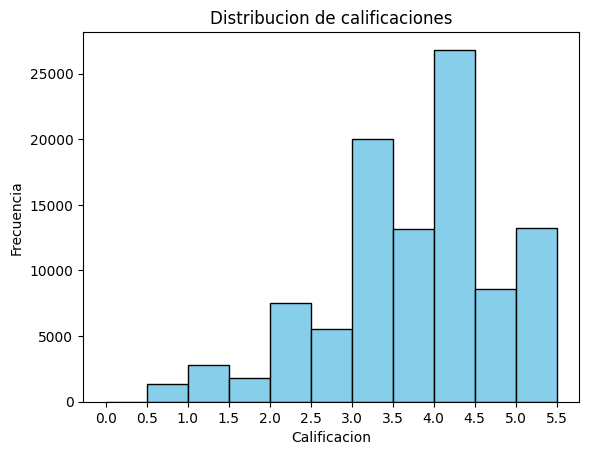

In [30]:
# 3. Distribucion de calificaciones
cur.execute("""
    SELECT rating, COUNT(*) as conteo
    FROM ratings
    GROUP BY rating
    ORDER BY rating
""")

bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5.0, 5.5]
plt.hist(df_ratings['rating'], bins=bins, edgecolor='black', color='skyblue')
plt.xticks(bins)
plt.title('Distribucion de calificaciones')
plt.xlabel('Calificacion')
plt.ylabel('Frecuencia')
plt.show()

 El histograma muestra que la mayoria de las calificaciones se concentran entre 3.0 y 4.5 con un pico cerca a 4.0, lo cual indica una tendencia positiva en la percepcion de las peliculas por parte de los usuarios. Las calificaciones bajas de 0.5 a 2.5 son menos frecuentes, lo que nos podria decir que los usuarios tienden a valorar mas positivamente las peliculas

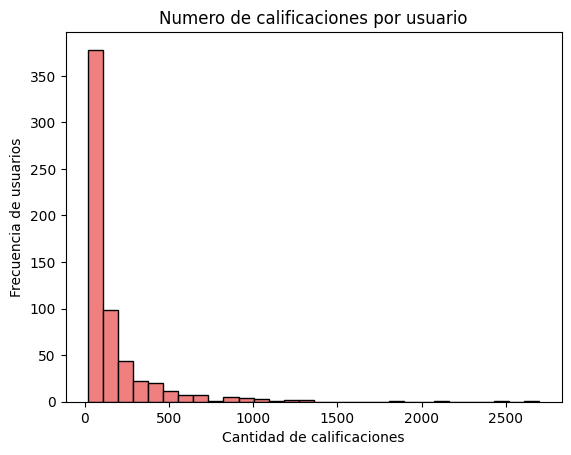

In [31]:
# 4. Numero de calficaciones por usuario
cur.execute("""
    SELECT userId, COUNT(*) as cnt_rating
    FROM ratings
    GROUP BY userId
""")
user_ratings = pd.DataFrame(cur.fetchall(), columns=['userId', 'cnt_rating'])

plt.hist(user_ratings['cnt_rating'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Numero de calificaciones por usuario')
plt.xlabel('Cantidad de calificaciones')
plt.ylabel('Frecuencia de usuarios')
plt.show()

En el grafico se puede notar una gran cantidad de usuarios que calificaron muy pocas veces (menos de 100), con un pico en los primeros intervalos. Sin embargo, tambien se observa una cola hacia la derecha que son los usuarios que han realizado mas de 500 calificaciones



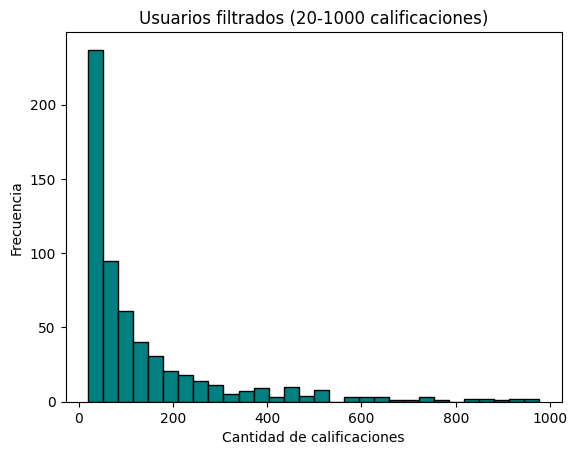

In [32]:
# 5. Usuarios filtrados (20-1000 calificaciones)
user_ratings_filtrado = user_ratings[(user_ratings['cnt_rating'] >= 20) & (user_ratings['cnt_rating'] <= 1000)]

plt.hist(user_ratings_filtrado['cnt_rating'], bins=30, color='teal', edgecolor='black')
plt.title('Usuarios filtrados (20-1000 calificaciones)')
plt.xlabel('Cantidad de calificaciones')
plt.ylabel('Frecuencia')
plt.show()

El grafico muestra que dentro del rango filtrado de usuarios que realizaron entre 20 y 1000 calificaciones, la mayoria esta en el segmento inferior, con un pico entre los 20 y 50 registros aproximadamente. A medida que aumenta la cantidad de calificaciones por usuario, la frecuencia disminuye considerablemente, lo que evidencia que aunque hay usuarios activos la gran mayoria tiene una participación moderada a la hora de valorar las peliculas

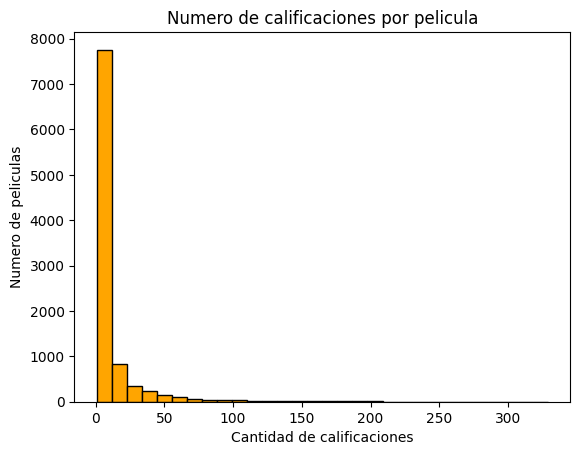

In [33]:
# 6. Numero de calificaciones por pelicula
cur.execute("""
    SELECT movieId, COUNT(*) as cnt_rating
    FROM ratings
    GROUP BY movieId
""")
movie_ratings = pd.DataFrame(cur.fetchall(), columns=['movieId', 'cnt_rating'])

plt.hist(movie_ratings['cnt_rating'], bins=30, color='orange', edgecolor='black')
plt.title('Numero de calificaciones por pelicula')
plt.xlabel('Cantidad de calificaciones')
plt.ylabel('Numero de peliculas')
plt.show()

El histograma muestra que la gran mayoria de las peliculas han recibido muy pocas calificaciones, concentrandose principalmente entre 0 y 20. Muy pocas peliculas han sido valoradas por muchos usuarios. Esto puede ser debido a una desigualdad en cuanto a la popularidad de estas

In [40]:
# Extraer el año y convertirlo a entero
df_movies['Year'] = pd.to_numeric(df_movies['title'].str.extract(r'\((\d{4})\)')[0], errors='coerce')
df_movies = df_movies.dropna(subset=['Year'])
df_movies['Year'] = df_movies['Year'].astype(int)

# Unir y agrupar
df_merged = pd.merge(df_ratings, df_movies[['movieId', 'Year']], on='movieId')
df_merged['Decada'] = (df_merged['Year'] // 10) * 10

# Asegurar tipo entero
df_merged['Decada'] = df_merged['Decada'].astype(int)

# Agrupar y ordenar
avg_ratings_per_group = df_merged.groupby('Decada', as_index=False)['rating'].mean().sort_values('Decada')

# Plotly interactivo con eje X limpio
import plotly.express as px

fig = px.bar(
    avg_ratings_per_group,
    x='Decada',
    y='rating',
    labels={'Decada': 'Década', 'rating': 'Promedio de Calificación'},
    title='Promedio de Calificaciones por Década',
    text='rating',
    color='rating',
    color_continuous_scale='Greens'
)

# Mejora visual
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=avg_ratings_per_group['Decada'].min(),
        dtick=10
    ),
    yaxis=dict(range=[0, 5]),
    uniformtext_minsize=8,
    uniformtext_mode='hide'
)

fig.show()

<ipython-input-40-196b561be0e1>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Se observa que las décadas de 1940 y 1950 obtuvieron los promedios más altos, con calificaciones de 3.87 y 3.85 respectivamente, lo que podría reflejar una época de consolidación artística y narrativa en el cine. A partir de la década de 1960, las calificaciones comienzan a mostrar una leve disminución, destacando un descenso más notorio desde los años 80 en adelante. Las décadas de 1990, 2000 y 2010 presentan los promedios más bajos, con valores cercanos a 3.4, lo cual podría estar relacionado con el aumento en la cantidad de producciones, la diversificación de contenidos o un cambio en los criterios de evaluación por parte del público.

In [50]:
# import pandas as pd

# # 1. Extraer el año desde el título en df_movies
# df_movies['Year'] = pd.to_numeric(df_movies['title'].str.extract(r'\((\d{4})\)')[0], errors='coerce')

# # 2. Unir las tablas por 'movieId'
# df_merged = pd.merge(df_ratings, df_movies[['movieId', 'title', 'Year']], on='movieId', how='inner')

# # 3. Agrupar por película y calcular el promedio de calificación y el número de votos
# df_avg_ratings = df_merged.groupby(['movieId', 'title', 'Year']).agg(
#     promedio_rating=('rating', 'mean'),
#     cantidad_rating=('rating', 'count')
# ).reset_index()

# # 4. Filtrar películas con una cantidad mínima de votos para evitar outliers (ej: al menos 50 votos)
# df_filtrado = df_avg_ratings[df_avg_ratings['cantidad_rating'] >= 50]

# # 5. Ordenar por mejor promedio
# df_top_peliculas = df_filtrado.sort_values(by='promedio_rating', ascending=False)

# # 6. Mostrar las top 20
# print("\nTop 20 películas mejor calificadas (con al menos 50 calificaciones):")
# display(df_top_peliculas.head(20))


Top 20 películas mejor calificadas (con al menos 50 calificaciones):


,movieId,title,Year,promedio_rating,cantidad_rating
277,318,"Shawshank Redemption, The (1994)",1994,4.429022,317
659,858,"Godfather, The (1972)",1972,4.289062,192
2224,2959,Fight Club (1999),1999,4.272936,218
974,1276,Cool Hand Luke (1967),1967,4.271930,57
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,1964,4.268041,97
686,904,Rear Window (1954),1954,4.261905,84
921,1221,"Godfather: Part II, The (1974)",1974,4.259690,129
6297,48516,"Departed, The (2006)",2006,4.252336,107
913,1213,Goodfellas (1990),1990,4.250000,126
694,912,Casablanca (1942),1942,4.240000,100


In [53]:
def consultar_rating_con_titulo(con, rating=5, graficar=False):
    import pandas as pd
    import matplotlib.pyplot as plt

    # Consulta SQL para traer ratings del valor dado y títulos de películas
    query = f"""
        SELECT r.movieId, m.title, r.rating
        FROM ratings r
        JOIN movies m ON r.movieId = m.movieId
        WHERE r.rating = {rating}
    """
    df_rating = pd.read_sql(query, con)

    # Verificar si se encontraron resultados
    if df_rating.empty:
        print(f"No se encontraron películas con calificación {rating}.")
        return

    # Mostrar conteo por película
    conteo = df_rating['title'].value_counts().reset_index()
    conteo.columns = ['Título de la película', f'Cantidad de calificaciones = {rating}']

    print(f"\nTop películas con calificación = {rating}:")
    display(conteo.head(20))

    # Graficar
    if graficar:
        plt.figure(figsize=(10, 5))
        conteo.head(10).plot(kind='barh', x='Título de la película',
                             y=f'Cantidad de calificaciones = {rating}',
                             color='mediumseagreen', edgecolor='black', legend=False)
        plt.title(f"Top 10 películas con calificación {rating}")
        plt.xlabel('Cantidad de calificaciones')
        plt.ylabel('Título de la película')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()


Top películas con calificación = 2:


,Título de la película,Cantidad de calificaciones = 2
0,Ace Ventura: Pet Detective (1994),27
1,Ace Ventura: When Nature Calls (1995),25
2,Batman Forever (1995),22
3,"Nutty Professor, The (1996)",20
4,Star Wars: Episode I - The Phantom Menace (1999),20
5,Waterworld (1995),19
6,True Lies (1994),17
7,Independence Day (a.k.a. ID4) (1996),17
8,Dumb & Dumber (Dumb and Dumber) (1994),16
9,Batman & Robin (1997),16


<Figure size 1000x500 with 0 Axes>

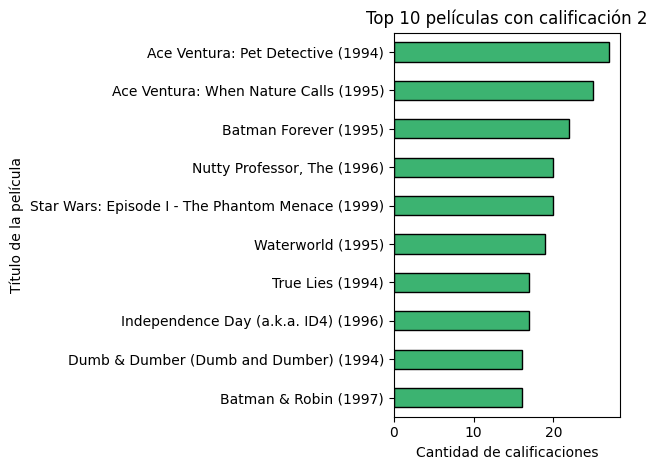

In [56]:
consultar_rating_con_titulo(con, rating=2, graficar=True)